In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.kernel_ridge import KernelRidge


In [2]:
from datetime import datetime, timedelta
from pandas_datareader import data, wb
import seaborn as sns
%matplotlib inline


In [3]:
def get_data(symbol, start, end):
    b = data.DataReader(symbol, 'yahoo', start=start, end=end)
    return b

def set_date_range(start_days_before_today,end_days_before_today):
    end=datetime.now().date()-timedelta(days=end_days_before_today)
    start=datetime.now().date()- timedelta(days=start_days_before_today)
    return start, end

#Function to get rolling mean of price
def getRollingMean(values, window):
    rm=pd.rolling_mean(values, window= window)
    rm.rename("Rolling Mean",inplace=True)
    return rm

#Function to get rolling Standard Deviation of price
def getRollingSD(values, window):
    rsd=pd.rolling_std(values, window= window)
    rsd=rsd.rename("Rolling SD",inplace=True)
    return rsd

def getMomentumLastWeek(df):
    momentum = df.copy()
    momentum[5:] = (df[5:] / df[:-5].values) - 1
    momentum[0:4] = 0
    momentum.rename('Momentum',inplace=True)
    return momentum

def getDailyReturns(df):
    dailyReturns = df.copy()
    dailyReturns[1:] = (df[1:] / df[:-1].values) - 1
    dailyReturns[0] = 0
    dailyReturns.rename('Daily Returns',inplace=True)
    return dailyReturns

def getNextDailyReturns(df):
    nextdr=df.copy()
    nextdr[:-1]=(df[1:]/df[:-1].values)-1
    nextdr[-1]=-1
    nextdr.rename('Next Day Returns',inplace=True)
    return nextdr

def Bollingerband(rm,rstd):
    upper_band=rm+2*rstd
    lower_band=rm-2*rstd
    upper_band.rename('Upper Band',inplace=True)
    lower_band.rename('Lower Band',inplace=True)
    return upper_band,lower_band


In [4]:
start,end=set_date_range(1080,0)
spy_first = get_data("SPY", start, end)
rolling_mean=getRollingMean(spy_first['Adj Close'],63)
rolling_std=getRollingSD(spy_first['Adj Close'],63)
momentum=getMomentumLastWeek(spy_first['Adj Close'])
DailyReturns=getDailyReturns(spy_first['Adj Close'])
rm_DR=getRollingMean(DailyReturns,63)
rm_DR=rm_DR.rename('RM DR')
rstd_DR=getRollingSD(DailyReturns,63)
rstd_DR=rstd_DR.rename('RSD DR')
sharpeRatio = rm_DR / rstd_DR
sharpeRatio=sharpeRatio.rename("Sharpie Ratio")
priceRMRatio = (spy_first['Adj Close'] / rolling_mean)
priceRMRatio=priceRMRatio.rename('Price RM Ratio')
bollinger = (rolling_mean - spy_first['Adj Close'])/(2 * rolling_std)
bollinger=bollinger.rename('Bollinger')

C:\Users\mcpea_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=63,center=False).mean()
C:\Users\mcpea_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=63,center=False).std()


In [5]:
spy_main=pd.concat([spy_first,rolling_mean,rolling_std,momentum,sharpeRatio,bollinger,priceRMRatio],axis=1)

In [6]:
spy_main.drop(['Open','High','Low','Close'],axis=1,inplace=True)

In [7]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

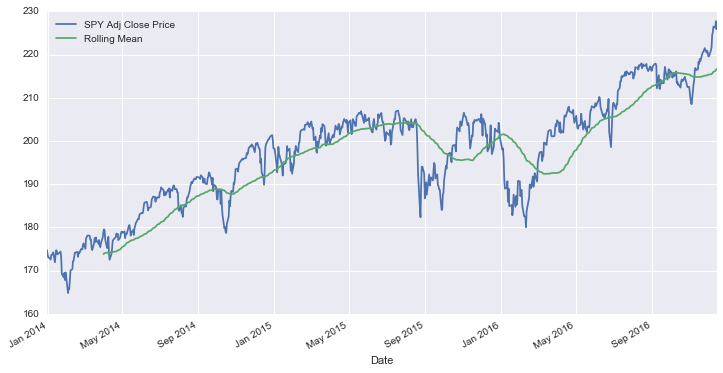

In [8]:
plt.figure(figsize=(12,6))
spy_main['Adj Close'].plot(label='SPY Adj Close Price')
spy_main['Rolling Mean'].plot(label='Rolling Mean')
plt.legend(loc='upper left')

plt.savefig('RM.jpg')

In [9]:
spy_complete=spy_main.dropna()
spy_complete.head()

,Volume,Adj Close,Rolling Mean,Rolling SD,Momentum,Sharpie Ratio,Bollinger,Price RM Ratio
Date,,,,,,,,
2014-03-31,99745000,177.757215,173.795168,3.253407,0.008521,0.050269,-0.608907,1.022797
2014-04-01,89193000,178.935869,173.874194,3.317246,0.010413,0.064211,-0.762933,1.029111
2014-04-02,78774000,179.534702,173.949655,3.391443,0.021139,0.061326,-0.823403,1.032107
2014-04-03,77435000,179.297072,174.047933,3.455689,0.021942,0.080254,-0.759492,1.030159
2014-04-04,169381000,177.177396,174.113016,3.475664,0.004906,0.053610,-0.440834,1.017600


In [76]:
spy=spy_complete.copy(deep=True)
spy.ix[:, 0:8] = (spy.ix[:, 0:8] - spy.ix[:, 0:8].min()) / (spy.ix[:, 0:8].max() - spy.ix[:, 0:8].min())
ndr_comp=getNextDailyReturns(spy_complete['Adj Close'])*100
spy=pd.concat([spy,ndr_comp],axis=1)

In [77]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

def LR(X_train, Y_train, X_test, Y_test):
    lr=LinearRegression()
    pred=lr.fit(X_train,Y_train).predict(X_test)
    result=np.sqrt(metrics.mean_squared_error(Y_test,pred))
    result2=np.sum(np.sign(pred)*np.sign(Y_test.values))
    return result,result2
    
def doLinearReg(X_train, Y_train, X_test, Y_test, l1_ratio):
    enet = ElasticNetCV(l1_ratio=l1_ratio, max_iter=1000000)
    enet_pred = enet.fit(X_train,Y_train).predict(X_test)
    result = np.sqrt(metrics.mean_squared_error(Y_test,enet_pred))
    result2=np.sum(np.sign(enet_pred)*np.sign(Y_test.values))
    return result,result2

#Function to do K-nearest neighbor
def doKNN(X_train, Y_train, X_test, Y_test, n_neighbors):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_pred = knn.fit(X_train,Y_train).predict(X_test)
    result = np.sqrt(metrics.mean_squared_error(Y_test, knn_pred))
    result2=np.sum(np.sign(knn_pred)*np.sign(Y_test.values))
    return result,result2

#Function to do kernel ridge regression
def doKernelRidge(X_train, Y_train, X_test, Y_test, gamma):
    kRidge = KernelRidge(alpha=1.0, gamma = gamma)
    kRidge_pred = kRidge.fit(X_train,Y_train).predict(X_test)
    result = np.sqrt(metrics.mean_squared_error(Y_test, kRidge_pred))
    result2=np.sum(np.sign(kRidge_pred)*np.sign(Y_test.values))
    return result,result2



0    0.980339
dtype: float64
0.0


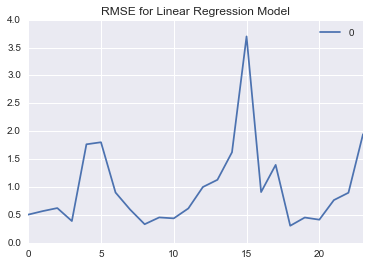

In [129]:
#Linear Regression
modeltest1=[]
modeltest2=[]
i = 63
step = 5
while (i + 5) < len(spy.index)-500:
        X_train = spy.ix[(i - 63):i, 0:-1]
        Y_train = spy.ix[(i - 63):i, -1]
        X_test = spy.ix[i : (i + 5), 0:-1]
        Y_test=spy.ix[i : (i + 5), -1]
        rms,scor=LR(X_train, Y_train, X_test, Y_test)
        modeltest1.append(rms)
        modeltest2.append(scor)
        i=i+step
res=pd.DataFrame(modeltest1)
res.plot(title='RMSE for Linear Regression Model')
plt.savefig('Final_Back_LR')
print(res.mean())
print(np.sum(modeltest2))        


0    0.702212
dtype: float64
10.0


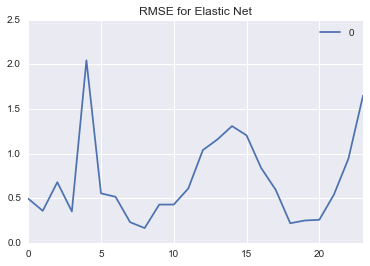

In [135]:
#Elastic Net
modeltest1=[]
modeltest2=[]
i = 63
step = 5 
while (i + 5) < len(spy.index)-500:
        X_train = spy.ix[(i - 63):i, 0:-1]
        Y_train = spy.ix[(i - 63):i, -1]
        X_test = spy.ix[i : (i + 5), 0:-1]
        Y_test=spy.ix[i : (i + 5), -1]
        rms,scor=doLinearReg(X_train, Y_train, X_test, Y_test, 0.5)
        modeltest1.append(rms)
        modeltest2.append(scor)
        i=i+step

res=pd.DataFrame(modeltest1)
res.plot(title='RMSE for Elastic Net')
plt.savefig('Final_BT_Elastic')
print(res.mean())
print(np.sum(modeltest2))

In [137]:
#KNN
fin=np.zeros(10)
score=np.zeros(10)
for k in range(40,50):
    modeltest1=[]
    modeltest2=[]
    i = 63
    step = 5
    while (i + 5) < len(spy.index)-500:
        X_train = spy.ix[(i - 63):i, 0:-1]
        Y_train = spy.ix[(i - 63):i, -1]
        X_test = spy.ix[i : (i + 5), 0:-1]
        Y_test=spy.ix[i : (i + 5), -1]
        rms,scor=doKNN(X_train, Y_train, X_test, Y_test, k)
        modeltest1.append(rms)
        modeltest2.append(scor)
        i = i + step
        
    res=pd.DataFrame(modeltest1)
    fin[k-40]=res.mean()
    score[k-40]=np.sum(modeltest2)

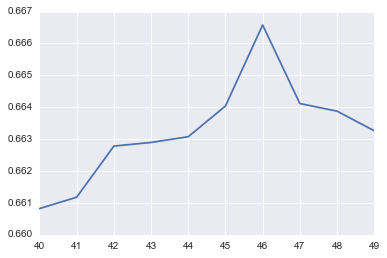

In [138]:
x=np.arange(40,50)
plt.plot(x,fin)
plt.savefig('Final_KNN_RMSE.jpg')

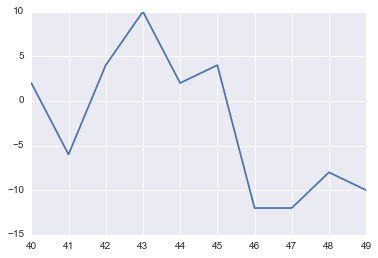

In [139]:
plt.plot(x,score)
plt.savefig('Final_BT_score_knn.jpg')

0    0.666953
dtype: float64
16.0


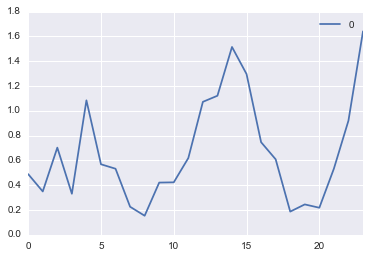

In [140]:
#Kernel Regression
modeltest1=[]
modeltest2=[]
i = 63
step = 5
spyDist = pd.DataFrame(squareform(pdist(spy, 'euclidean')))
sRange = range(0,3)
while (i + 5) < len(spy.index)-500:
        X_train = spy.ix[(i - 63):i, 0:-1]
        Y_train = spy.ix[(i - 63):i, -1]
        X_test = spy.ix[i : (i + 5), 0:-1]
        Y_test=spy.ix[i : (i + 5), -1]
        rms,scor=doKernelRidge(X_train, Y_train, X_test, Y_test,sRange[0])
        modeltest1.append(rms)
        modeltest2.append(scor)
        i = i + step
        
res=pd.DataFrame(modeltest1)
res.plot()
plt.savefig('Final_BT_Kernel.jpg')
print(res.mean())
print(np.sum(modeltest2))

In [125]:
#Final Model
final_df=spy.copy(deep=True)
final_df['State']=0
i = len(spy.index)-500
step = 5
spyDist = pd.DataFrame(squareform(pdist(final_df, 'euclidean')))
sRange = range(0,3)

    #Simulating the strategy 
while (i + 5) < len(final_df.index):
    X_train = final_df.ix[(i - 63):i, 0:8]
    Y_train = final_df.ix[(i - 63):i, -2]
    X_test = final_df.ix[i : (i + 5), 0:8]
    kRidge = KernelRidge(alpha=1.0, gamma = sRange[0])
    kRidge_pred = kRidge.fit(X_train,Y_train).predict(X_test)
    final_df.ix[i : (i + 5),-1] = np.sign(kRidge_pred)
    i = i + step


In [126]:
final_df['Predicted Return'] = final_df['Next Day Returns'] * final_df['State']

In [127]:
result2 = final_df[['Next Day Returns', 'Predicted Return']]
result2 = result2.ix[len(final_df.index)-500:-5,:]
result2['SPY'] = result2['Next Day Returns']
result2['Strategy'] = result2['Predicted Return']
result2.ix[0,2] = 100
result2.ix[0, 3] = 100

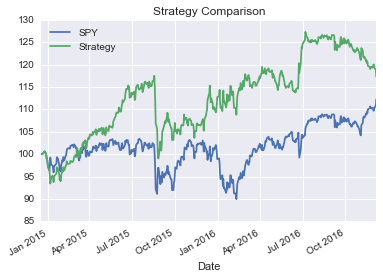

In [141]:
for i in range(1,len(result2.index)):
    result2.ix[i, 2] = ((result2.ix[i - 1, 2])/100) * (100 + result2.ix[i, 0])
    result2.ix[i, 3] = ((result2.ix[i - 1, 3]) / 100) * (100 + result2.ix[i, 1])

ax = result2[['SPY', 'Strategy']].plot(title = 'Strategy Comparison')
plt.savefig('Final_strategy_kernel.jpg')